In [9]:
import os, sys, glob, json, scipy as sp
import matplotlib.pyplot as plt
import itertools
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen
from GWGen.DressedFluxes import *
import numpy as np
from numpy import array
import scipy as sp
import time
import scipy.optimize as spopt
import scipy.interpolate as spint
import glob
import matplotlib.pyplot as plt
import re
alpha_match_1 = re.compile("Alpha_\d+_\d+")
alpha_match_2 = re.compile("Alpha_\d+")
modeovertonematch = re.compile("Mode_1_Overtone_0")
alpha_rege = re.compile("\d+")
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)
allfilenames=glob.glob(pathToSolutionSet+"BHSpin*")

In [ ]:

alldata = [np.load(i) for i in allfilenames]
modeovertonebool  = [bool(re.search("Mode_1_Overtone_0",i.fid.name)) for i in alldata]
newalldata =[]
for inx,boolval in enumerate(modeovertonebool):
    if boolval:
        newalldata.append(alldata[inx])
alldata = newalldata

In [ ]:
interpdat = []
for inx,dat in enumerate(alldata):
    raddat = dat["RadialData"]
    thetdat = dat["ThetaData"][0:100]
    nonnanthetdat = notnan(thetdat)
    if len(nonnanthetdat)>100:
        nonnanthetdat[0:100]
    endat = dat["EnergyData"][:,nonnanthetdat]
    interpfunc = spint.RectBivariateSpline(raddat,thetdat[nonnanthetdat],endat)
    alphastr = alpha_match_1.findall(dat.fid.name)
    if len(alphastr)==0:
        alphastr=alpha_match_2.findall(dat.fid.name)
    if isinstance(alphastr, str):
        pass
    elif isinstance(alphastr,list):
        alphastr=alphastr[0]
    alphapieces = alpha_rege.findall(alphastr)
    if len(alphapieces)>1:
        alphavalue = float(alphapieces[0])/float(alphapieces[1])
    else:
        alphavalue = float(alphapieces[0])
    out = [alphavalue,min(raddat), max(raddat), min(thetdat), max(thetdat), interpfunc]
    interpdat.append(out)

In [ ]:
alphavals = []
maxradial = []
maxendens = []
interpsfuncs = []
for inx, interptuple in enumerate(interpdat):
    alpha, minr,maxr,mint,maxt,interpfunc = interptuple
    rad = 50
    thet = np.pi/2
    interpdata = interpfunc(rad,thet)
    maxenden = max(interpdata)
    maxradial.append(maxr)
    alphavals.append(alpha)
    maxendens.append(maxenden)
    interpsfuncs.append(interpfunc)

In [ ]:
indexsort = np.argsort(alphavals)
sorted_alphavals = np.asarray(alphavals)[indexsort]
sorted_interpfuncs = np.asarray(interpsfuncs)[indexsort]
sorted_maxradial = np.asarray(maxradial)[indexsort]

In [ ]:
takenumber = 2
take_alphavalues = sorted_alphavals[:takenumber]
minmaxrad = min(sorted_maxradial[:takenumber])
maxmaxrad = max(sorted_maxradial[:takenumber])
radialdom = np.arange(minr, minmaxrad,1)
take_interpfuncs = sorted_interpfuncs[:takenumber]

In [ ]:
energydata

In [ ]:
aa =time.time()
alpharange = take_alphavalues
radialrange = radialdom[:int(len(radialdom)/3)]
thetarange = thetdat
energydata = np.asarray([i(radialrange,thetarange) for i in take_interpfuncs])
RGI = spint.RegularGridInterpolator((alpharange,radialrange,thetarange), energydata, fill_value=None, bounds_error=False, method="linear")
bb=time.time()
print(bb-aa)
coords = cartesian_product(np.array([0.065]), radialrange, thetarange)
dd=time.time(); print("coords: ", dd-bb)
RGIdata = np.reshape(RGI(coords), ( len(radialrange), len(thetarange)))
cc=time.time(); print("RGI data: ",cc-dd)
RBI = spint.RectBivariateSpline(radialrange, thetarange, RGIdata)
print(time.time()-cc)

In [ ]:
tmpRBIdata = RBI(radialrange, thetarange)[:,50]
tmpRGIdata = RGIdata[:,50]
plt.plot(tmpRBIdata)
plt.plot(tmpRGIdata)
plt.show();
plt.plot(tmpRBIdata-tmpRGIdata);

In [ ]:
coords = np.asarray([[alpha, r, theta] for alpha in alpharange for r in radialdom for theta in thetarange])

In [ ]:
energydatain = np.ravel(energydata)
rbfint = spint.RBFInterpolator(coords,energydatain, neighbors=800,kernel="linear",smoothing=0,degree=0)

In [ ]:
neighbordata = ProcaSolution._ProcaSolution__get_closest_datasets(1,0.0703415,0.85)
alphane = neighbordata["alphaneighbors"]
spinne = neighbordata["bhspinneighbors"]
datasets = neighbordata["datasets"]

radialdata = [i["RadialData"] for i in datasets]
thetadata = [i["ThetaData"] for i in datasets]
newshape = (int(min([len(i) for i in radialdata])/7),100)
radialdata = [i[:newshape[0]] for i in radialdata]
thetadata = [i[:newshape[1]] for i in thetadata]

rawen = [i["EnergyData"][:newshape[0], :newshape[1]] for i in datasets]
rawenoldshape = np.shape(rawen)
#first index denotes bh spin value
#second index denotes alpha value
#third denotes radial value
#fourth denotes theta value
rawenreshaped = np.reshape(rawen, (2,2,rawenoldshape[1],rawenoldshape[2]))

if not len(np.unique(spinne))==len(spinne) and not len(np.unique(alphane))==len(alphane):
    interp = spint.RegularGridInterpolator((radialdata[0], thetadata[0]), rawenreshaped[0][0])
    coords = cartesian_product(np.array(radialdata[0]), np.array(thetadata[0]))
if not len(np.unique(spinne))==len(spinne) and len(np.unique(alphane))==len(alphane):
    interp = spint.RegularGridInterpolator((alphane, radialdata[0], thetadata[0]), rawenreshaped[0])
    coords = cartesian_product(np.array([0.07]), np.array(radialdata[0]), np.array(thetadata[0]))

if len(np.unique(spinne))==len(spinne) and not len(np.unique(alphane))==len(alphane):
    interp = spint.RegularGridInterpolator((spinne, radialdata[0], thetadata[0]), rawenreshaped[:,0])
    coords = cartesian_product(np.array([0.85]),np.array(radialdata[0]), np.array(thetadata[0]))

if len(np.unique(spinne))==len(spinne) and len(np.unique(alphane))==len(alphane):
    interp = spint.RegularGridInterpolator((spinne, alphane, radialdata[0], thetadata[0]), rawenreshaped)
    coords = cartesian_product(np.array([0.85]), np.array([0.07]),np.array(radialdata[0]), np.array(thetadata[0]))

values = np.reshape(interp(coords), newshape)
interp = spint.RectBivariateSpline(radialdata[0], thetadata[0], values)

## Sorting Proca Data

First sort by BHspin values, then group by alpha values and take neighboring data

In [12]:
test_bhspin = 0.79
test_alpha = 0.135

In [18]:
aa=time.time()
bhspins = list(map(BHSpinValFromFilename,allfilenames))
unsorted_alphavalues = list(map(AlphaValFromFilename, allfilenames))
index_sort = np.argsort(bhspins)
bhspins = np.array(bhspins)[index_sort]
allfilenames = np.array(allfilenames)[index_sort]
res=itertools.groupby(allfilenames, BHSpinValFromFilename)
sorted_filenames={}
for key,group in res:
    grouplist = list(group)
    alphas = list(map(AlphaValFromFilename, grouplist))
    index_sort = np.argsort(alphas)
    sorted_group = np.array(grouplist)[index_sort]
    sorted_filenames[key] = sorted_group
bhspins = list(sorted_filenames.keys())
rindex = bisect_right(bhspins,test_bhspin)
Larger_BHSpin_Datasets = sorted_filenames[bhspins[rindex]]
Smaller_BHSpin_Datasets = sorted_filenames[bhspins[rindex-1]]
Smaller_BHSpin_AlphaValues = list(map(AlphaValFromFilename, Smaller_BHSpin_Datasets))
Larger_BHSpin_AlphaValues = list(map(AlphaValFromFilename, Larger_BHSpin_Datasets))
assert test_alpha>Smaller_BHSpin_AlphaValues[0] and test_alpha<Smaller_BHSpin_AlphaValues[-1] and test_alpha>Larger_BHSpin_AlphaValues[0] and test_alpha<Larger_BHSpin_AlphaValues[-1], "Error: Alpha value outside range of available data"
rindex_smaller = bisect_right(Smaller_BHSpin_AlphaValues, test_alpha)
rindex_larger = bisect_right(Larger_BHSpin_AlphaValues, test_alpha)
SmallerSmaller_Dataset = Smaller_BHSpin_Datasets[rindex_smaller-1]
SmallerLarger_Dataset = Smaller_BHSpin_Datasets[rindex_smaller]
LargerSmaller_Dataset = Larger_BHSpin_Datasets[rindex_larger-1]
LargerLarger_Dataset = Larger_BHSpin_Datasets[rindex_larger]
smallsmalldata = np.load(SmallerSmaller_Dataset)
smalllargedata = np.load(SmallerLarger_Dataset)
largesmalldata = np.load(LargerSmaller_Dataset)
largelargedata = np.load(LargerLarger_Dataset)
geninterp = lambda dat: spint.RectBivariateSpline(dat["RadialData"], dat["ThetaData"], dat["EnergyData"])
smallsmallinterp = geninterp(smallsmalldata)
smalllargeinterp = geninterp(smalllargedata)
largesmallinterp = geninterp(largesmalldata)
largelargeinterp = geninterp(smalllargedata)

time.time()-aa

0.058860063552856445

In [ ]:
print(SmallerSmaller_Dataset)
print(SmallerLarger_Dataset)
print(LargerSmaller_Dataset)
print(LargerLarger_Dataset)

In [ ]:
print(test_bhspin)
print(test_alpha)

In [ ]:
39/50

In [ ]:
bhspins

# Check output of GWGen.DressedFluxes.Fluxes.ProcaSolution

In [50]:
M=1e6
spin=0.879
mu = 3.8e-17
alpha =alphavalue(M,mu)
alpha

<Quantity 0.28435925>

In [51]:
pc = ProcaSolution(M,spin,mu)

test_alpha = alpha
test_bhspin = spin
bhspins = list(map(BHSpinValFromFilename,allfilenames))
unsorted_alphavalues = list(map(AlphaValFromFilename, allfilenames))
index_sort = np.argsort(bhspins)
bhspins = np.array(bhspins)[index_sort]
allfilenames = np.array(allfilenames)[index_sort]
res=itertools.groupby(allfilenames, BHSpinValFromFilename)
sorted_filenames={}
for key,group in res:
    grouplist = list(group)
    alphas = list(map(AlphaValFromFilename, grouplist))
    index_sort = np.argsort(alphas)
    sorted_group = np.array(grouplist)[index_sort]
    sorted_filenames[key] = sorted_group
bhspins = list(sorted_filenames.keys())
rindex = bisect_right(bhspins,test_bhspin)
Larger_BHSpin_Datasets = sorted_filenames[bhspins[rindex]]
Smaller_BHSpin_Datasets = sorted_filenames[bhspins[rindex-1]]
Smaller_BHSpin_AlphaValues = list(map(AlphaValFromFilename, Smaller_BHSpin_Datasets))
Larger_BHSpin_AlphaValues = list(map(AlphaValFromFilename, Larger_BHSpin_Datasets))
assert test_alpha>Smaller_BHSpin_AlphaValues[0] and test_alpha<Smaller_BHSpin_AlphaValues[-1] and test_alpha>Larger_BHSpin_AlphaValues[0] and test_alpha<Larger_BHSpin_AlphaValues[-1], "Error: Alpha value outside range of available data"
rindex_smaller = bisect_right(Smaller_BHSpin_AlphaValues, test_alpha)
rindex_larger = bisect_right(Larger_BHSpin_AlphaValues, test_alpha)
SmallerSmaller_Dataset = Smaller_BHSpin_Datasets[rindex_smaller-1]
SmallerLarger_Dataset = Smaller_BHSpin_Datasets[rindex_smaller]
LargerSmaller_Dataset = Larger_BHSpin_Datasets[rindex_larger-1]
LargerLarger_Dataset = Larger_BHSpin_Datasets[rindex_larger]
smallsmalldata = np.load(SmallerSmaller_Dataset)
smalllargedata = np.load(SmallerLarger_Dataset)
largesmalldata = np.load(LargerSmaller_Dataset)
largelargedata = np.load(LargerLarger_Dataset)
geninterp = lambda dat: spint.RectBivariateSpline(dat["RadialData"], dat["ThetaData"], dat["EnergyData"])
smallsmallinterp = geninterp(smallsmalldata)
smalllargeinterp = geninterp(smalllargedata)
largesmallinterp = geninterp(largesmalldata)
largelargeinterp = geninterp(smalllargedata)

UltralightBoson instance not provided. Instantiating class...
done.


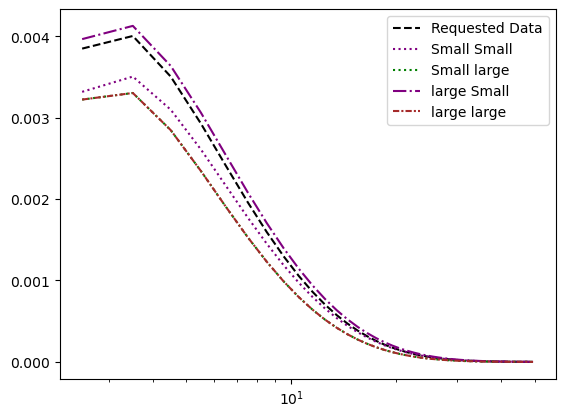

In [52]:
raddat = pc.radial_data[:300]
plotfun = plt.semilogx
plotfun(raddat, pc.enden(raddat,pc.theta_data[50]), label="Requested Data", linestyle="--",color="black")
plotfun(raddat, smallsmallinterp(raddat, pc.theta_data[50]), label="Small Small", linestyle="dotted",color="purple")
plotfun(raddat, smalllargeinterp(raddat, pc.theta_data[50]), label="Small large", linestyle="dotted",color="green")
plotfun(raddat, largesmallinterp(raddat, pc.theta_data[50]), label="large Small",linestyle="dashdot",color="Purple")
plotfun(raddat, largelargeinterp(raddat, pc.theta_data[50]), label="large large",linestyle=(0, (3, 1, 1, 1)),color="brown")
plt.legend()